In [4]:
%%time
import ijson
import pandas as pd
from pathlib import Path

#file year 
year = 2025
file_path = f"new_amplitude_export_{year}.json"

#non-empty columns
columns_keep = [
    "$insert_id",
    "amplitude_id",
    "app",
    "city",
    "client_event_time",
    "client_upload_time",
    "country",
    "data",
    "data_type",
    "device_family",
    "device_id",
    "device_type",
    "dma",
    "event_id",
    "event_properties",
    "event_time",
    "event_type",
    "language",
    "library",
    "os_name",
    "os_version",
    "platform",
    "processed_time",
    "region",
    "server_received_time",
    "server_upload_time",
    "session_id",
    "user_id",
    "user_properties",
    "uuid",
]
path = Path(f"{year}_csv")
if not path.exists():
    path.mkdir(parents=True, exist_ok=True)
#use ijson to read the json files efficiently in memory
with open(file_path, "r") as f:
    objects = ijson.items(f, "item") #creates a generator object
    
    batch_size = 100000 #can be updated, currently saves per batches of 100,000
    chunk = []
    count = 0 #used to index batch file
    for obj in objects:
        chunk.append(obj)
        if len(chunk) >= batch_size:
            df = pd.DataFrame(chunk)
            output_csv = f"{year}_csv/{file_path.split('.')[0]}_chunk_{count*batch_size}_{(count+1)*batch_size}.csv"
            df = df[columns_keep] #remove empty columns
            df.to_csv(output_csv, index=False)
            count += 1
            chunk = []

    if chunk: #process remaining data if any
        output_csv = f"{year}_csv/{file_path.split('.')[0]}_chunk_{count*batch_size}_{(count+1)*batch_size}.csv"
        df = pd.DataFrame(chunk)
        df = df[columns_keep]
        df.to_csv(output_csv, index=False)


CPU times: user 2min 1s, sys: 38.4 s, total: 2min 40s
Wall time: 3min 13s


In [5]:
%%time
import ijson
import pandas as pd
from pathlib import Path

#file chunk 
part = 1
file_path = f"new_export/amplitude_export_chunk_{part}_anonymized.json"

#non-empty columns
columns_keep = [
    "$insert_id",
    "amplitude_id",
    "app",
    "city",
    "client_event_time",
    "client_upload_time",
    "country",
    "data",
    "data_type",
    "device_family",
    "device_id",
    "device_type",
    "dma",
    "event_id",
    "event_properties",
    "event_time",
    "event_type",
    "language",
    "library",
    "os_name",
    "os_version",
    "platform",
    "processed_time",
    "region",
    "server_received_time",
    "server_upload_time",
    "session_id",
    "user_id",
    "user_properties",
    "uuid",
]

path = Path(f"{part}_csv")
if not path.exists():
    path.mkdir(parents=True, exist_ok=True)

#use ijson to read the json files efficiently in memory
with open(file_path, "r") as f:
    objects = ijson.items(f, "item") #creates a generator object
    
    batch_size = 100000 #can be updated, currently saves per batches of 100,000
    chunk = []
    count = 0 #used to index batch file
    for obj in objects:
        chunk.append(obj)
        if len(chunk) >= batch_size:
            df = pd.DataFrame(chunk)
            output_csv = f"{part}_csv/{file_path.split('/')[1].split('.')[0]}_subchunk_{count*batch_size}_{(count+1)*batch_size}.csv"
            df = df[columns_keep] #remove empty columns
            df.to_csv(output_csv, index=False)
            count += 1
            chunk = []

    if chunk: #process remaining data if any
        output_csv = f"{part}_csv/{file_path.split('/')[1].split('.')[0]}_subchunk_{count*batch_size}_{(count+1)*batch_size}.csv"
        df = pd.DataFrame(chunk)
        print(df.shape)
        df = df[columns_keep]
        print(df.shape)
        df.to_csv(output_csv, index=False)


(83027, 54)
(83027, 30)
CPU times: user 54 s, sys: 16.6 s, total: 1min 10s
Wall time: 1min 19s


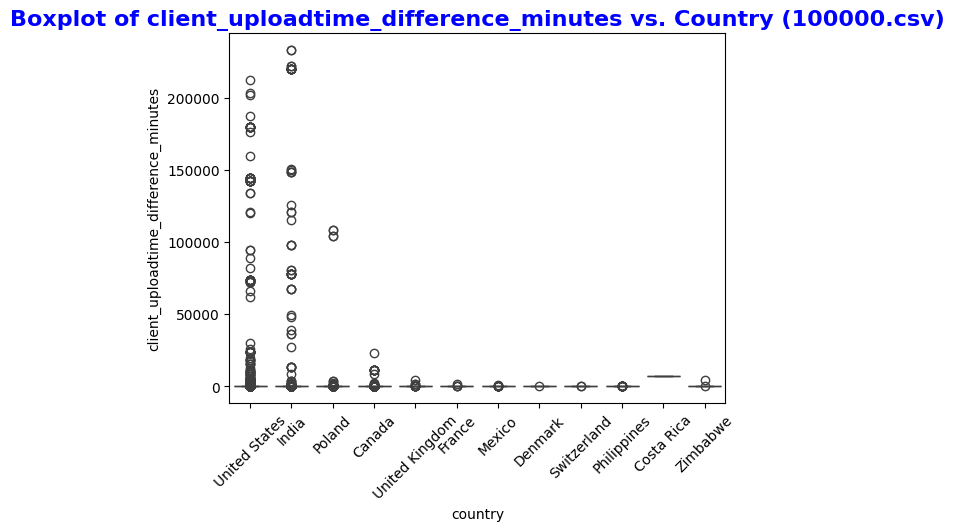

In [132]:
import pandas as pd
import numpy as new_export
import matplotlib.pyplot as plt
import seaborn as sns
# if getting error message, make sure to install matplotlib using pip install

## here is the specified file the code will examine
PATH = '1_csv/amplitude_export_chunk_1_anonymized_subchunk_0_100000.csv'
df = pd.read_csv(PATH)
# See the first couple rows of dataset
df.head()

# Generates a summary of statistics for the columns in the dataste
df.describe(include='all')

df['client_event_time'] = pd.to_datetime(df['client_event_time'])
df['client_upload_time'] = pd.to_datetime(df['client_upload_time'])


# Add new columns for 'event_date' and 'event_time'
#df['client_event_timestamp'] = df['client_event_time'].dt.time   # Extracts the time part
#df['client_upload_timestamp'] = df['client_upload_time'].dt.time   # Extracts the time part

df['time_difference'] = df['client_upload_time'] - df['client_event_time']
df['time_difference_minutes'] = df['time_difference'].dt.total_seconds() / 60


# Created a new column titled client_uploadtime_difference_minutes which combined client_event_time and client_upload_tine

df['client_uploadtime_difference_minutes'] = df['time_difference'].dt.total_seconds() / 60

# Summary of statistics on the upload time from client
df['time_difference'].describe()

df.loc[df['time_difference'].idxmax()]

#pd.crosstab(df['country'], df['device_type'])
df.groupby('device_type')['client_uploadtime_difference_minutes'].mean()

sns.boxplot(x='country', y='client_uploadtime_difference_minutes', data=df)
plt.title('Boxplot of client_uploadtime_difference_minutes vs. Country (100000.csv)', fontsize=16, color='blue', fontweight='bold')
plt.xticks(rotation=45)
plt.show()



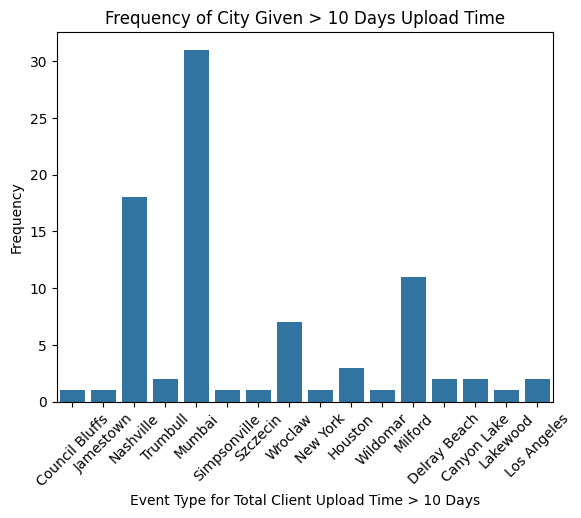

3

In [116]:
# Exploring those with upload times greater than _ days (input in minutes)
filtered_df = df[df['time_difference_minutes'] > 14400]
filtered_df.describe(include='all')

sns.countplot(x='city', data=filtered_df)
plt.xlabel('Event Type for Total Client Upload Time > 10 Days')
plt.ylabel('Frequency')
plt.title('Frequency of City Given > 10 Days Upload Time')

# Rotate x-axis labels if they are crowded
plt.xticks(rotation=45)

plt.show()

unique_values_count = df['language'].nunique()
unique_values_count

In [117]:
## Checking to see if client_event_time is the same as event_time

# Creating a dataset with just the client_event_time and event_time columns
new_df = df[['client_event_time', 'event_time']]
new_df.head()

## Check the number of unique values in each column
unique_values = new_df.nunique()

# Check if all columns are equal to eachother in each row
new_df['All_Equal'] = new_df.eq(new_df.iloc[:, 0], axis=0).all(axis=1)

# This code proved that client_event_time = event_time

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_19625/1985162257.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['All_Equal'] = new_df.eq(new_df.iloc[:, 0], axis=0).all(axis=1)


In [119]:
## Performing EDA on columns: client_event_time, client_upload_time, client_uploadtime_difference_minutes
##      which on are on a new dataset titled: client_time_df

client_time_df = df.loc[:,['client_event_time', 'client_upload_time', 'client_uploadtime_difference_minutes']]

# Displays mean, min, 25%, 50%, 75%, max, std on the three columns
client_time_df.describe()

# Find rows where event time is later than upload time
#client_time_df.loc[:, 'upload_time_negative'] = client_time_df['client_uploadtime_difference_minutes'] < 0

# Print the rows where the upload time is negative
#print(client_time_df[client_time_df['upload_time_negative']])


# Print rows with negative total upload time
#print(client_time_df[client_time_df['upload_time_negative']])

,client_event_time,client_upload_time,client_uploadtime_difference_minutes
count,83027,83027,83027.000000
mean,2024-09-22 05:42:17.885005824,2024-09-22 07:41:48.630737408,119.512429
min,2024-03-31 02:35:19.616000,2024-03-31 02:35:20.880000,-2.725367
25%,2024-07-15 22:08:54.629499904,2024-07-15 22:09:18.559500032,0.017217
50%,2024-10-10 18:35:29.415000064,2024-10-10 18:36:19.377999872,0.020100
75%,2024-11-18 07:21:39.633500160,2024-11-18 07:23:09.910000128,0.029883
max,2024-12-24 03:59:47.749000,2024-12-24 03:59:48.634000,281180.373917
std,NaN,NaN,4114.232759


In [141]:
## Combining all 2024 csv files into 1
import glob
csv_files1 = glob.glob('1_csv/*.csv')

# Read and combine all 2024 csv files
combined_df = pd.concat([pd.read_csv(file) for file in csv_files1], ignore_index=True)

# Save the combined df to a new csv file
combined_df.to_csv('2024combined_file.csv', index=False)


## Combining all 2025 csv files into 1
csv_files2 = glob.glob('2025_csv/*.csv')

# Read and combine all 2024 csv files
combined_df = pd.concat([pd.read_csv(file) for file in csv_files2], ignore_index=True)

# Save the combined df to a new csv file
combined_df.to_csv('2025combined_file.csv', index=False)

/var/folders/rw/2_yr05hd56b1rkq4976bf6w00000gn/T/ipykernel_19625/1137695234.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(file) for file in csv_files1], ignore_index=True)
